In [1]:
import pandas as pd
import numpy as np
from functions import *

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

In [3]:
# """ Load Labeled Dataset """
dataset = pd.read_pickle('./compliance_labeled_data.pkl')

# Train & Test Split

In [4]:
"""
1 -> False Positive Compliance Sentence
0 -> True Positive Compliance Sentence
"""

dataset.label = dataset.label.map(lambda x: 0 if x==-1 else x)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset['sentences'], dataset['label'], stratify=dataset['label'], random_state=42)
X_train.shape, X_test.shape

((2479,), (827,))

# K Nearest Neighbors (KNN) MODEL

In [7]:
def get_neighbors_from_emb(test_vecs, train_vecs, k=11, threshold=0.0):
    
    if (len(test_vecs)==0) or (len(train_vecs)==0):
        return pd.DataFrame(columns=['neighbors'])
    
    test_emb = np.matrix(test_vecs.tolist())
    train_emb = np.matrix(train_vecs.tolist())
    
    similarity = cosine_similarity(test_emb, train_emb)
    neighbors = []
    similarity = np.round(similarity, 2)
    
    for i in range(similarity.shape[0]): 
        states = (similarity[i] >= threshold) & (similarity[0] <= 1)
        indices = np.where(states)[0]
        indices = indices[np.argsort(similarity[i][indices])[::-1][:k]]
        sim_scores = np.round(similarity[i][indices], 4)
        neighbors.append(list(tuple(zip(indices, sim_scores))))
    
    return pd.DataFrame([neighbors], index=['neighbors']).T

# Bag of Words Approach (TF-IDF) - Text2Vec

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cloud_user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# As not is useful to understand the context of the sentence,
# exclude it from stop words list
retain_words = ['no','not']
for w in retain_words:
    try:
        stopWords.remove(w)
    except:
        pass

'not' in stopWords

False

In [10]:
vectorizer = TfidfVectorizer(use_idf=True, stop_words = stopWords)
vectorizer.fit(X_train.values.tolist())

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [11]:
train_vecs = vectorizer.transform(X_train.values.tolist()).toarray()
test_vecs = vectorizer.transform(X_test.values.tolist()).toarray()


In [12]:
""" Compute Neighbors for Test Set """
neighbors = get_neighbors_from_emb(test_vecs, train_vecs)

In [13]:
""" Get Respective Training and Test Labels """
neighbors.neighbors = neighbors.neighbors.map(lambda x: [(a[0], a[1], y_train.iloc[a[0]]) for a in x])
neighbors['true_label'] = y_test.reset_index(drop=True)

In [14]:
get_prediction_at_k =lambda k, predictions: pd.Series([a[-1] for a in predictions[:k]]).value_counts().index[0]

In [15]:
model_result = pd.DataFrame(columns=['Accuracy'])
for k in range(1, 12, 2):
    neighbors['prediction_at_'+str(k)] = neighbors.neighbors.apply(lambda x: get_prediction_at_k(k, x))
    acc = sum(neighbors['prediction_at_'+str(k)] == neighbors['true_label'])/neighbors.shape[0]
    model_result.loc[k] = acc

In [16]:
def plot_analysis(model_name, model):
    ax = model.plot(xticks=model.index, marker='o')
    ax.set_title('{} Approach'.format(model_name), weight='bold', size=11)
    ax.set_xlabel("Number of Neighbors (K)", labelpad=10, size=10)
    ax.set_ylabel("Accuracy", labelpad=10, size=10)
    ax.grid(True,linewidth=0.4)
    # plt.legend(model.columns[1:],loc='best', bbox_to_anchor=(1.0, 1.0),fontsize=12)
    plt.legend(loc='best',fancybox=True, shadow=True, ncol=model.columns.shape[0]-1)

    # plt.savefig('../data/cbow.jpg', format='jpg', quality=100, dpi=300, pad_inches=5)
    plt.show()

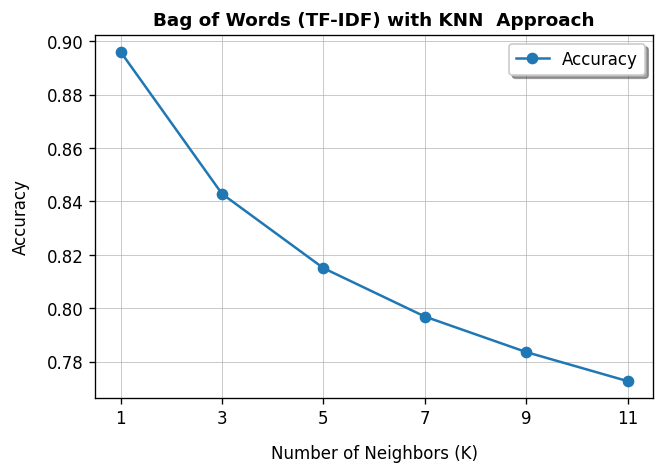

In [18]:
plot_analysis('Bag of Words (TF-IDF) with KNN ', model_result)

In [20]:
neighbors.loc[:,"sentences"] = X_test.values

In [ ]:
"""
1 - False Positive Compliance Sentence
0 - True Positive Compliance Sentence
"""

In [48]:
neighbors[neighbors.prediction_at_1==0]['sentences'].iloc[18]

'The fine should double each day the Houston based company fails to comply with document requests the committee said'

In [ ]:
"""
False-Positive Compliance Related Discussions:

- 'Legal and compliance have made progress'
- 'Review all advertising for compliance with FTC regulations trademark usage and adherence to corporate policies'
- 'As written FERC has discretion to defer to NERC or an RTO to monitor and enforce compliance'

"""

"""
True-Positive Compliance Related Discussions:

- 'It appears to me that it is typical FERC behavior FERC likes to use whatever leverage it has to force compliance'
- 'The compliance meeting last week underscored that point'
- 'The fine should double each day the Houston based company fails to comply with document requests the committee said'

- 'Please note that while Non Registered ESPs do not have ongoing reporting and compliance requirements with the CPUC both Registered ESPs and Non Registered ESPs must submit various environmental compliance filings with the California Energy Commission and if participating in the Green e Program make additional filings with the Center for Resource Solutions'
- 'In addition not withstanding our policy of prohibiting employees from buying or selling securities of an advertising company for a period of 20 days following dissemination of the advertisement we may not be able to effectively monitor our employees to ensure compliance with the same'

- 'I was asked the terms under which we were prepared to negotiate and I told them at a minimum upon a commitment by the Indian authorities to serious negotiations which would include full compliance with the terms of the contracts and progress in the reform of the MSEB'
- 'MG s back office systems required substantial adjustment to comply with Enron s standards the company s statement said'
- 'What is important now however is not so much compliance with accounting rules but whether Edison ultimately has a path to recover its costs'


"""


In [ ]:
neighbors.to_pickle('./bow_results.pkl')

# Fasttext

In [21]:
import fasttext
import unidecode

In [22]:
training_data_path = './fasttext_unsup_data.txt'
with open(training_data_path, 'w') as f:
    f.write(unidecode.unidecode('\n'.join(X_train.values.tolist())))

In [ ]:
""" Custom FastText Model """
model = fasttext.train_unsupervised(training_data_path,'skipgram', lr=0.025,epoch=25,word_ngrams=2,bucket=200000,dim=300)


In [23]:
""" Pretrained FastText Model """

# Download pre-trained models from here: https://fasttext.cc/docs/en/pretrained-vectors.html
pretrained = fasttext.load_model('./fasttext_simple_wiki.bin')
model = pretrained

In [24]:
""" Generate Fasttext based text embeddings """
get_fasttext_sent_emb = lambda sent : model.get_sentence_vector(unidecode.unidecode(sent.lower().replace('\n',' ')))


In [25]:
train_vecs = np.array([get_fasttext_sent_emb(s) for s in X_train.values.tolist()])
test_vecs =  np.array([get_fasttext_sent_emb(s) for s in X_test.values.tolist()])

In [26]:
""" Compute Neighbors for Test Set """
neighbors = get_neighbors_from_emb(test_vecs, train_vecs)
neighbors.neighbors = neighbors.neighbors.map(lambda x: [(a[0], a[1], y_train.iloc[a[0]]) for a in x])
neighbors['true_label'] = y_test.reset_index(drop=True)

In [27]:
model_result = pd.DataFrame(columns=['Accuracy'])
for k in range(1, 12, 2):
    neighbors['prediction_at_'+str(k)] = neighbors.neighbors.apply(lambda x: get_prediction_at_k(k, x))
    acc = sum(neighbors['prediction_at_'+str(k)] == neighbors['true_label'])/neighbors.shape[0]
    model_result.loc[k] = acc

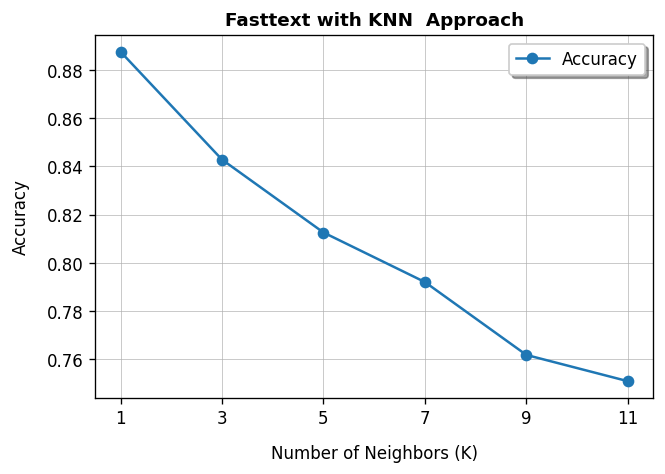

In [28]:
plot_analysis('Fasttext with KNN ', model_result)

# Word2Vec

In [29]:
from gensim.models import Word2Vec

In [30]:
training_data_path = './fasttext_unsup_data.txt'

In [31]:
model_cbow = Word2Vec(corpus_file=training_data_path, size=300, window=5, min_count=1, workers=4, sg=0, compute_loss=True)
model_skipgram = Word2Vec(corpus_file=training_data_path, size=300, window=5, min_count=1, workers=4, sg=1, compute_loss=True)

In [32]:
model = model_skipgram # model_cbow or model_skipgram
vocab = model.wv.vocab.keys()
get_word2vec_mean_emb = lambda sent : np.sum([model.wv.word_vec(word.lower().strip()) for word in sent.split() if word.lower().strip() in vocab], axis=0)


In [33]:
train_vecs = np.array([get_word2vec_mean_emb(s) for s in X_train.values.tolist()])
test_vecs =  np.array([get_word2vec_mean_emb(s) for s in X_test.values.tolist()])

In [34]:
""" Compute Neighbors for Test Set """
neighbors = get_neighbors_from_emb(test_vecs, train_vecs)
neighbors.neighbors = neighbors.neighbors.map(lambda x: [(a[0], a[1], y_train.iloc[a[0]]) for a in x])
neighbors['true_label'] = y_test.reset_index(drop=True)

In [35]:
model_result = pd.DataFrame(columns=['Accuracy'])
for k in range(1, 12, 2):
    neighbors['prediction_at_'+str(k)] = neighbors.neighbors.apply(lambda x: get_prediction_at_k(k, x))
    acc = sum(neighbors['prediction_at_'+str(k)] == neighbors['true_label'])/neighbors.shape[0]
    model_result.loc[k] = acc

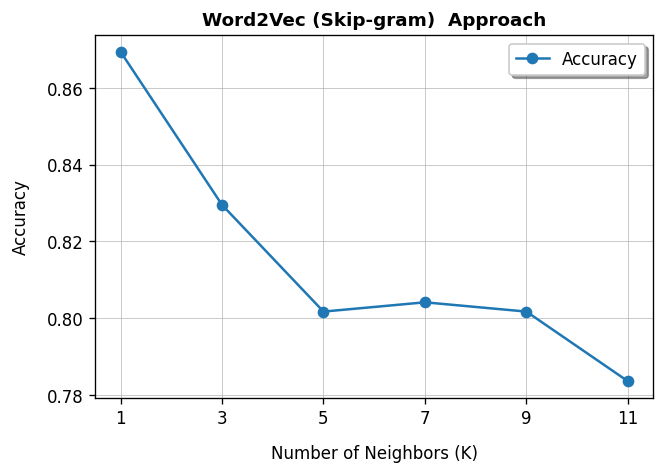

In [36]:
plot_analysis('Word2Vec (Skip-gram) ', model_result)

# LSTM Network

In [37]:
# Average Sentence consists of ~34 words
dataset.sentences.str.split().map(len).describe()

count    3306.000000
mean       34.445251
std        26.545508
min         4.000000
25%        21.000000
50%        28.000000
75%        41.000000
max       313.000000
Name: sentences, dtype: float64

In [38]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd



tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(dataset.sentences.values)
x_train = tokenizer.texts_to_sequences(X_train)
x_test = tokenizer.texts_to_sequences(X_test)

vocab_size=len(tokenizer.word_index)+1

maxlen=50 # Average Sentence consists of ~34 words,so let's consider 50
x_train=pad_sequences(x_train,padding='post', maxlen=maxlen)
x_test=pad_sequences(x_test,padding='post', maxlen=maxlen) 


Using TensorFlow backend.


In [39]:

epochs = 20
embedding_dim=100
model=Sequential()
model.add(layers.Embedding(input_dim=vocab_size,output_dim=embedding_dim,input_length=maxlen))
model.add(layers.LSTM(units=50,return_sequences=True))
model.add(layers.LSTM(units=10))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(x_train, y_train,validation_split=0.10,epochs=epochs, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(x_test, y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           531000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 50)            30200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                2440      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 563,737
Trainable params: 563,737
Non-trainable params: 0
________________________________________________

/home/cloud_user/anaconda3/envs/ticket_resolution/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2231 samples, validate on 248 samples
Epoch 1/20
2231/2231 [==============================] - 6s 3ms/step - loss: 0.6826 - accuracy: 0.5805 - val_loss: 0.6744 - val_accuracy: 0.5887
Epoch 2/20
2231/2231 [==============================] - 5s 2ms/step - loss: 0.6483 - accuracy: 0.6212 - val_loss: 0.5364 - val_accuracy: 0.7540
Epoch 3/20
2231/2231 [==============================] - 4s 2ms/step - loss: 0.5006 - accuracy: 0.8005 - val_loss: 0.4366 - val_accuracy: 0.8347
Epoch 4/20
2231/2231 [==============================] - 4s 2ms/step - loss: 0.3716 - accuracy: 0.8705 - val_loss: 0.4161 - val_accuracy: 0.8266
Epoch 5/20
2231/2231 [==============================] - 3s 1ms/step - loss: 0.3055 - accuracy: 0.9104 - val_loss: 0.3924 - val_accuracy: 0.8629
Epoch 6/20
2231/2231 [==============================] - 3s 1ms/step - loss: 0.2654 - accuracy: 0.9274 - val_loss: 0.3885 - val_accuracy: 0.8508
Epoch 7/20
2231/2231 [==============================] - 4s 2ms/step - loss: 0.2401 - accu

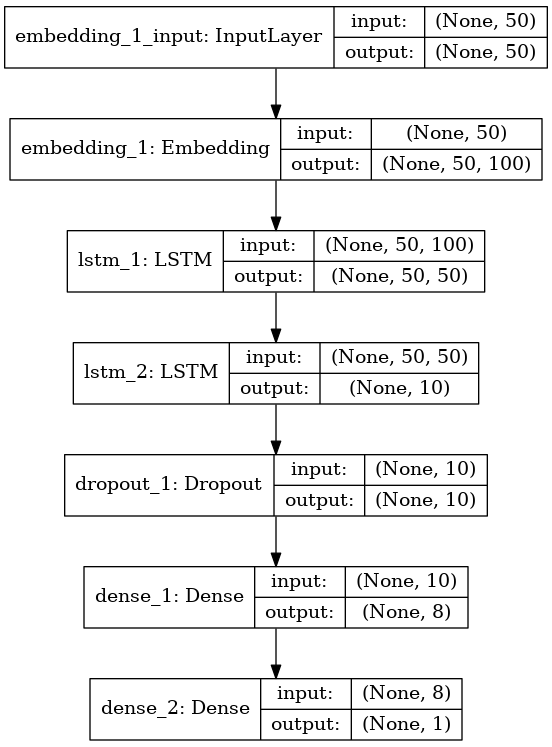

In [40]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,expand_nested=True)

In [41]:
def plot_analysis_dl(model_name, model, type_=''):
#     model_name = 'CBOW'
    model.columns = ['Training','Validation']
    ax = model.plot(xticks=model.index, marker='*')
    ax.set_title(model_name, weight='bold', size=11)
    ax.set_xlabel("Number of Iterations (Epochs)", labelpad=10, size=10)
    ax.set_ylabel(type_, labelpad=10, size=10)
    ax.grid(True,linewidth=0.4)
    # plt.legend(model.columns[1:],loc='best', bbox_to_anchor=(1.0, 1.0),fontsize=12)
#     plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),fancybox=True, shadow=True, ncol=model.columns.shape[0]-1)

    # plt.savefig('../data/cbow.jpg', format='jpg', quality=100, dpi=300, pad_inches=5)
    plt.show()

In [42]:
model_history = pd.DataFrame(model.history.history, index=np.arange(1,epochs+1))

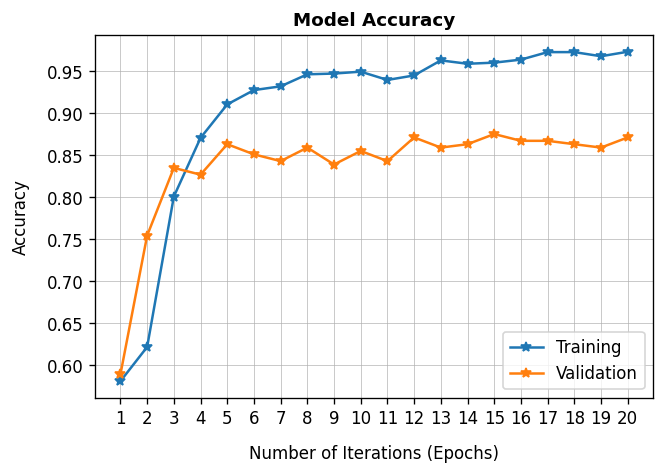

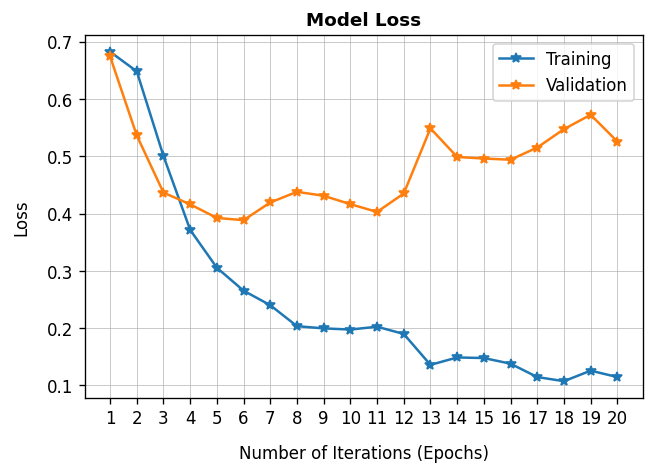

In [43]:
plot_analysis_dl('Model Accuracy', model_history[['accuracy','val_accuracy']], 'Accuracy')
plot_analysis_dl('Model Loss', model_history[['loss','val_loss']], 'Loss')

# ===========================================
# ------------- Steps for System Improvement ------------- 
# ===========================================


- For a new email, perform sentence tokenization.
- For all sentences, perform classification by applying any ML model (as implemented above).
- Alert Email if any of the sentence is labeled as “0” (it means compliance related discussion found).
- Scenario Analyst should be presented with the tokenized labeled sentences.
- User can change the label of any sentence if marked incorrect by Classifier.
- Update or add new labeled sentences to dataset and retrain the model.

## In Production:

- Perform Sentence tokenization on email
- Classify each sentence
- If any of the sentence's output is 0, raise that Email to compliance dept.